# Part 1: Risk Factors of Election Violence
Part 1 aims to identify the most important risk factors of election-related violence across global historical elections

In [2]:
# import libraries

import os
import pandas as pd
pd.set_option('display.max_columns',100)
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import plotly.io as pio
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# load data

data_path = '/content/drive/MyDrive/data606-capstone/William Simpson - Capstone 606/3. Datasets'

deco = pd.read_csv(os.path.join(data_path,'DECO_v.1.0.csv'))
nelda = pd.read_excel(os.path.join(data_path,'NELDA.xls'))
nelda_look_up = pd.read_excel(os.path.join(data_path,'nelda_look_up.xlsx'))

In [7]:
# inspect original data shapes prior to processing

print('DECO:', deco.shape)
print('NELDA:', nelda.shape)

DECO: (4233, 41)
NELDA: (4158, 124)


# 2. Exploratory Data Analysis (EDA)

### 2.1 EDA of NELDA

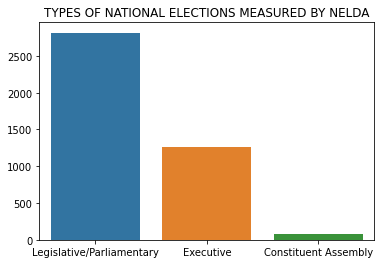

In [ ]:
# types of elections in dataset

election_types = nelda.types.value_counts()
sns.barplot(x=election_types.index, 
            y=election_types.values)
plt.title('TYPES OF NATIONAL ELECTIONS MEASURED BY NELDA')
plt.show()

In [ ]:
# count of national elections measured in NELDA

nelda_count = nelda.groupby(['country']).count()['electionid'].copy().reset_index()
nelda_count = nelda_count.rename(columns={'electionid':'Count of Elections'})

fig = px.choropleth(nelda_count,
                    locations='country', 
                    locationmode="country names",
                    projection='natural earth',
                    scope="world",
                    color='Count of Elections',
                    color_continuous_scale="PuBu", 
                    title='National Elections Measured in NELDA (1945-2020)'
                    )
fig.update_layout(
    title={
        'text': 'National Elections Measured in NELDA (1945-2020)',
        'y':0.85,
        'x':0.455,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

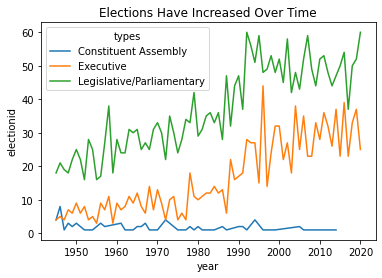

In [ ]:
# elections over time

nelda_year = nelda.groupby(['year','types']).count()['electionid'].reset_index()

sns.lineplot(x=nelda_year.year,
             y=nelda_year.electionid,
            hue=nelda_year.types)
plt.title('Elections Have Increased Over Time')
plt.show()

### 2.2 EDA of DECO data

In [ ]:
# count of election related fatalities in DECO

deco_count = deco.groupby(['country']).sum()['best'].copy().reset_index()
deco_count = deco_count.rename(columns={'best':'Count of Fatalities'})

fig = px.choropleth(deco_count,
                    locations='country', 
                    locationmode="country names",
                    projection='natural earth',
                    scope="world",
                    color='Count of Fatalities',
                    color_continuous_scale="OrRd", 
                    title='Election-related Fatalities based on Events Coded in DECO (1989-2017)'
                    )
fig.show()

In [ ]:
# examine density of election violence incidents in selected case study country: KENYA
deco_kenya = deco.loc[deco.country == 'Kenya'].copy()

fig = px.density_mapbox(deco_kenya, lat='latitude', lon='longitude', radius=10,
                        center=dict(lat=0.1, lon=38), zoom=5,
                        mapbox_style="stamen-terrain",
                        width=600, height=600)
fig.show()

In [ ]:
# election violence over time

# deco_year = deco.groupby(['']).count()['id'].reset_index()
deco_ = deco.copy()
deco_.date_start = pd.to_datetime(deco_.date_start)

deco_year = deco_.groupby(['year']).count()['id'].reset_index()


fig = px.scatter(deco_year,
          x='year',
          y='id',
          trendline='ols',
          title='GLOBAL ELECTION VIOLENCE IS INCREASING',
          labels={'id':'Number of Fatal Events', 'year':'Year'})

fig.show()

# 3. Data Cleaning and Preprocessing

### 3.1 Clean each dataset

In [37]:
# clean NELDA data of historical elections for modeling

def process_nelda(nelda_data):
    
    # select only applicable data
    nelda_data = nelda_data.loc[(nelda_data.year > 1988) & (nelda_data.year < 2018)]  # select years covered by DECO 1989-2017
    deco_country_ids = list(deco.country_id.unique())
    nelda_data = nelda_data.loc[nelda_data.ccode.isin(deco_country_ids)]  # select only countries that appear in DECO
    
    # remove notes column
    nelda_data = nelda_data[[col for col in nelda_data.columns if not re.match(".+notes$", col)]]
    
    # exclude free text features of names and location
    free_txt_cols = ['nelda43', 'nelda44', 'nelda54']
    nelda_data = nelda_data[[col for col in nelda_data.columns if col not in free_txt_cols]]
    
    # fill NaN as 'N/A' for Nelda columsn 
    nelda_cols = [col[0] for col in [re.findall(r'nelda\d+$', col) for col in nelda_data.columns] if len(col)>=1]
    for col in nelda_cols:
        nelda_data[col] = nelda_data[col].fillna('n/a')
    
    # convert string features to numeric
    def str_to_num(string):
        if string == 'yes':
            return 2
        elif string == 'no':
            return 1
        elif string == 'n/a': 
            return 0
        else:  # unclear
            return -1
        
    # apply string conversion function    
    for col in nelda_cols:
        nelda_data[col] = [str_to_num(val) for val in nelda_data[col]]
    
    return nelda_data

In [38]:
# apply cleaning function

nelda_clean = process_nelda(nelda)

In [40]:
# view cleaned data

nelda_clean

,stateid,ccode,country,electionid,year,mmdd,types,notes,nelda1,nelda2,nelda3,nelda4,nelda5,nelda6,nelda7,nelda8,nelda9,nelda10,nelda11,nelda12,nelda13,nelda14,nelda15,nelda16,nelda17,nelda18,nelda19,nelda20,nelda21,nelda22,nelda23,nelda24,nelda25,nelda26,nelda27,nelda28,nelda29,nelda30,nelda31,nelda32,nelda33,nelda34,nelda35,nelda36,nelda37,nelda38,nelda39,nelda40,nelda41,nelda42,nelda45,nelda46,nelda47,nelda48,nelda49,nelda50,nelda51,nelda52,nelda53,nelda55,nelda56,nelda57,nelda58
122,HAI,41,Haiti,041-1990-1216-L1,1990,1216,Legislative/Parliamentary,NaN,2,2,2,2,2,0,0,0,0,2,2,1,1,1,1,1,1,2,2,1,0,0,0,0,1,0,0,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,2,1,1,2,0
123,HAI,41,Haiti,041-1990-1216-L2,1991,120,Legislative/Parliamentary,NaN,2,2,2,2,2,0,0,0,0,2,2,-1,1,1,-1,-1,1,2,2,1,0,0,0,0,-1,0,-1,-1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,-1,-1,-1,-1,0,0,2,0
124,HAI,41,Haiti,041-1990-1216-P1,1990,1216,Executive,NaN,2,2,2,2,2,0,2,2,1,2,2,-1,1,1,1,-1,1,2,2,2,1,1,0,0,-1,0,2,1,0,0,0,1,2,1,0,0,0,0,2,2,1,1,2,2,1,1,1,-1,0,0,-1,0,0,2,0
125,HAI,41,Haiti,041-1995-0625-L1,1995,625,Legislative/Parliamentary,The first of a two-round election. A rerun of ...,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0
126,HAI,41,Haiti,041-1995-0625-L2,1995,917,Legislative/Parliamentary,Boycotted by most opposition groups. There was...,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,FJI,950,Fiji,950-1994-0218-L1,1994,218,Legislative/Parliamentary,NaN,1,1,2,2,2,2,0,0,0,1,1,1,1,1,1,1,1,2,2,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1,1,2,1,1,2,1,1,1,1
4010,FJI,950,Fiji,950-1999-0508-L1,1999,508,Legislative/Parliamentary,NaN,1,1,2,2,2,2,1,1,1,1,1,2,1,1,1,1,1,2,2,2,2,0,0,2,2,2,2,1,1,0,0,1,1,1,0,0,0,0,2,2,1,1,1,0,0,2,1,2,1,1,2,1,1,1,1
4011,FJI,950,Fiji,950-2001-0825-L1,2001,825,Legislative/Parliamentary,NaN,1,1,2,2,2,2,1,1,1,1,1,2,1,1,2,1,1,2,2,2,2,0,0,1,2,2,1,1,1,0,0,1,1,1,0,0,0,0,1,0,0,0,2,2,1,1,1,1,0,0,2,1,2,1,2
4012,FJI,950,Fiji,950-2006-0506-L1,2006,506,Legislative/Parliamentary,NaN,1,1,2,2,2,1,1,1,1,1,1,2,1,1,1,1,2,1,1,2,2,0,0,1,2,1,2,2,1,0,0,1,1,1,0,0,0,0,1,0,0,0,2,2,1,1,1,2,1,1,2,1,1,1,1


In [50]:
# clean data of election violence (DECO) for modeling

def process_deco(deco_data):
    
    # aggregate deaths by year and country
    deco_data = deco_data[['year', 'country_id', 'best']]
    deco_data = deco_data.rename(columns={'best':'num_fatalities'})
    deco_data = deco_data.groupby(by=['year', 'country_id']).sum()
    
    return deco_data.reset_index()

In [51]:
# preview deco

deco

,id,type_of_violence,conflict_new_id,conflict_name,dyad_new_id,side_a_new_id,side_a,side_b_new_id,side_b,country_id,country,region,source_article,year,date_start,date_end,deaths_a,deaths_b,civilian_deaths,unknown,best,high,low,latitude,longitude,electoral_vio,electoral_vio_uncertainty,electoral_vio_source,electoral_purpose,electoral_side_a,electoral_side_a_2,electoral_side_a_inc,electoral_side_b,electoral_side_b_2,electoral_side_b_inc,electoral_perpetrator,electoral_targets,electoral_type,electoral_timing,relid,ucdp_ged
0,95,1,230,Yemen (North Yemen):Government,10855,123,Government of Yemen (North Yemen),1091,Ansarallah,678,Yemen (North Yemen),Middle East,"Agence France Presse, 2012-02-21, Four killed ...",2012,2/21/2012,2/21/2012,0,0,1,0,1,1,1,12.779444,45.036667,1,0,NaN,disrupt,Public officials,NaN,1,Political supporters,NaN,0,2,2,2,2,YEM-2012-1-X2626-4,0
1,96,1,230,Yemen (North Yemen):Government,10855,123,Government of Yemen (North Yemen),1091,Ansarallah,678,Yemen (North Yemen),Middle East,"Agence France Presse, 2012-02-21, Four killed ...",2012,2/21/2012,2/21/2012,1,0,0,0,1,1,1,12.779444,45.036667,1,0,NaN,disrupt,Security forces,NaN,1,Political supporters,NaN,0,2,6,2,2,YEM-2012-1-X2626-5,0
2,175,2,5036,Supporters of General Peoples Congress - Suppo...,5646,3425,Supporters of General Peoples Congress,2374,Supporters of Islah party,678,Yemen (North Yemen),Middle East,"Reuters 1997-04-21 ""Yemeni man killed in pre-e...",1997,4/20/1997,4/20/1997,0,0,0,1,1,1,1,13.969184,43.996728,1,0,NaN,divergent affiliations,Political supporters,NaN,1,Political supporters,NaN,1,3,3,1,1,YEM-1997-2-X4857-1,0
3,265,1,230,Yemen (North Yemen):Government,10855,123,Government of Yemen (North Yemen),1091,Ansarallah,678,Yemen (North Yemen),Middle East,"Agence France Presse, 2012-02-09, Two killed i...",2012,2/9/2012,2/9/2012,0,2,0,0,2,2,2,13.695723,44.73137,1,0,NaN,crack down on protest and/or riot,Security forces,NaN,1,Political supporters,NaN,0,1,5,2,1,YEM-2012-1-X2626-2,0
4,266,1,230,Yemen (North Yemen):Government,10855,123,Government of Yemen (North Yemen),1091,Ansarallah,678,Yemen (North Yemen),Middle East,"Rueters News, 2012-02-20,WRAPUP 3-Violence hit...",2012,2/20/2012,2/20/2012,0,1,0,0,1,1,1,13.695723,44.73137,1,0,NaN,crack down on protest and/or riot,Security forces,NaN,1,Political supporters,NaN,0,1,5,2,1,YEM-2012-1-X2626-3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4228,253925,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,10/31/2017,10/31/2017,0,0,1,0,1,1,1,-1.283333,36.816667,1,1,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-70,1
4229,253926,4,13998,Government of Kenya - Opponents of Kenyatta,15173,91,Government of Kenya,6777,Opponents of Kenyatta,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,11/17/2017,11/17/2017,0,0,0,1,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-4-15173-57,0
4230,253927,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,11/20/2017,11/20/2017,0,0,1,0,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-73,1
4231,253928,3,469,Government of Kenya - Civilians,936,91,Government of Kenya,1,Civilians,501,Kenya,Africa,"""Human Rights Watch,2018-02-25,Kenya: Fresh Ev...",2017,11/28/2017,11/28/2017,0,0,1,0,1,1,1,-1.283333,36.816667,1,2,NaN,crack down on protest and/or riot,Security forces,NaN,1,Civilians,NaN,0,1,5,2,3,KEN-2017-3-936-74,1


In [52]:
# apply cleaning function

deco_agg = process_deco(deco)

In [53]:
# view cleaned data

deco_agg

,year,country_id,num_fatalities
0,1989,51,1
1,1989,70,4
2,1989,93,83
3,1989,135,663
4,1989,200,1
...,...,...,...
460,2017,640,6
461,2017,645,42
462,2017,750,12
463,2017,790,4


### 3.2 Combine NELDA and DECO datasets

In [61]:
# merge DECO target variable on year and country with NELDA

combined_nelda_deco = nelda_clean.merge(deco_agg, how='left', left_on=['ccode','year'], right_on=['country_id', 'year'])

In [62]:
# Imputation for NaN number of fatalities 

# NaN means that the election did not have any election-related fatal events as defined by DECO
# Thus, impute NaN as ZERO fatalities 
combined_nelda_deco.num_fatalities = combined_nelda_deco.num_fatalities.fillna(0)

In [63]:
# Drop unecessary columns 

combined_nelda_deco = combined_nelda_deco.drop(['country_id','stateid','ccode', 'country', 'electionid', 'year', 'mmdd', 'types', 'notes'], axis=1)

In [64]:
# view combined data that will be used in modeling

# all NELDA variables will be used as independent variables to predict the dependent variable,
# which is the best estimate of election related fatalities for that country-year.
combined_nelda_deco.reset_index(inplace=True, drop=True)
combined_nelda_deco

,nelda1,nelda2,nelda3,nelda4,nelda5,nelda6,nelda7,nelda8,nelda9,nelda10,nelda11,nelda12,nelda13,nelda14,nelda15,nelda16,nelda17,nelda18,nelda19,nelda20,nelda21,nelda22,nelda23,nelda24,nelda25,nelda26,nelda27,nelda28,nelda29,nelda30,nelda31,nelda32,nelda33,nelda34,nelda35,nelda36,nelda37,nelda38,nelda39,nelda40,nelda41,nelda42,nelda45,nelda46,nelda47,nelda48,nelda49,nelda50,nelda51,nelda52,nelda53,nelda55,nelda56,nelda57,nelda58,num_fatalities
0,2,2,2,2,2,0,0,0,0,2,2,1,1,1,1,1,1,2,2,1,0,0,0,0,1,0,0,1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,2,1,1,2,0,7.0
1,2,2,2,2,2,0,0,0,0,2,2,-1,1,1,-1,-1,1,2,2,1,0,0,0,0,-1,0,-1,-1,1,0,0,1,2,1,0,0,0,0,0,0,0,0,2,2,1,1,1,-1,-1,-1,-1,0,0,2,0,50.0
2,2,2,2,2,2,0,2,2,1,2,2,-1,1,1,1,-1,1,2,2,2,1,1,0,0,-1,0,2,1,0,0,0,1,2,1,0,0,0,0,2,2,1,1,2,2,1,1,1,-1,0,0,-1,0,0,2,0,7.0
3,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,0.0
4,2,1,2,2,2,0,0,1,1,1,2,1,1,2,1,1,1,2,2,1,0,0,0,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,2,2,1,1,1,2,1,1,1,0,0,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,1,2,2,2,2,0,0,0,1,1,1,1,1,1,1,1,2,2,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,1,1,2,1,1,2,1,1,1,1,0.0
948,1,1,2,2,2,2,1,1,1,1,1,2,1,1,1,1,1,2,2,2,2,0,0,2,2,2,2,1,1,0,0,1,1,1,0,0,0,0,2,2,1,1,1,0,0,2,1,2,1,1,2,1,1,1,1,1.0
949,1,1,2,2,2,2,1,1,1,1,1,2,1,1,2,1,1,2,2,2,2,0,0,1,2,2,1,1,1,0,0,1,1,1,0,0,0,0,1,0,0,0,2,2,1,1,1,1,0,0,2,1,2,1,2,0.0
950,1,1,2,2,2,1,1,1,1,1,1,2,1,1,1,1,2,1,1,2,2,0,0,1,2,1,2,2,1,0,0,1,1,1,0,0,0,0,1,0,0,0,2,2,1,1,1,2,1,1,2,1,1,1,1,0.0


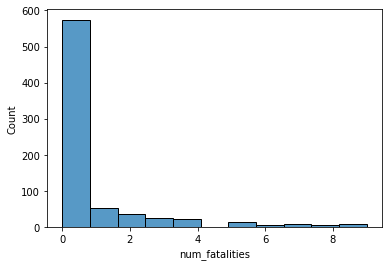

In [66]:
# visualize the distribution of fatalities 

sns.histplot(combined_nelda_deco.num_fatalities.loc[combined_nelda_deco.num_fatalities < 10])
plt.show()

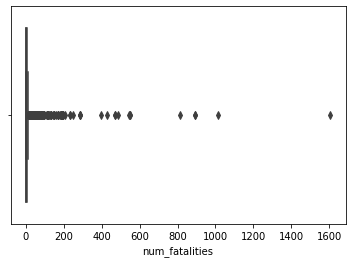

In [68]:
# alternative visualization of fatalities distribution
sns.boxplot(x = combined_nelda_deco.num_fatalities)
plt.show()

### 3.3 Examine Correlations for Possible Multicolinearities

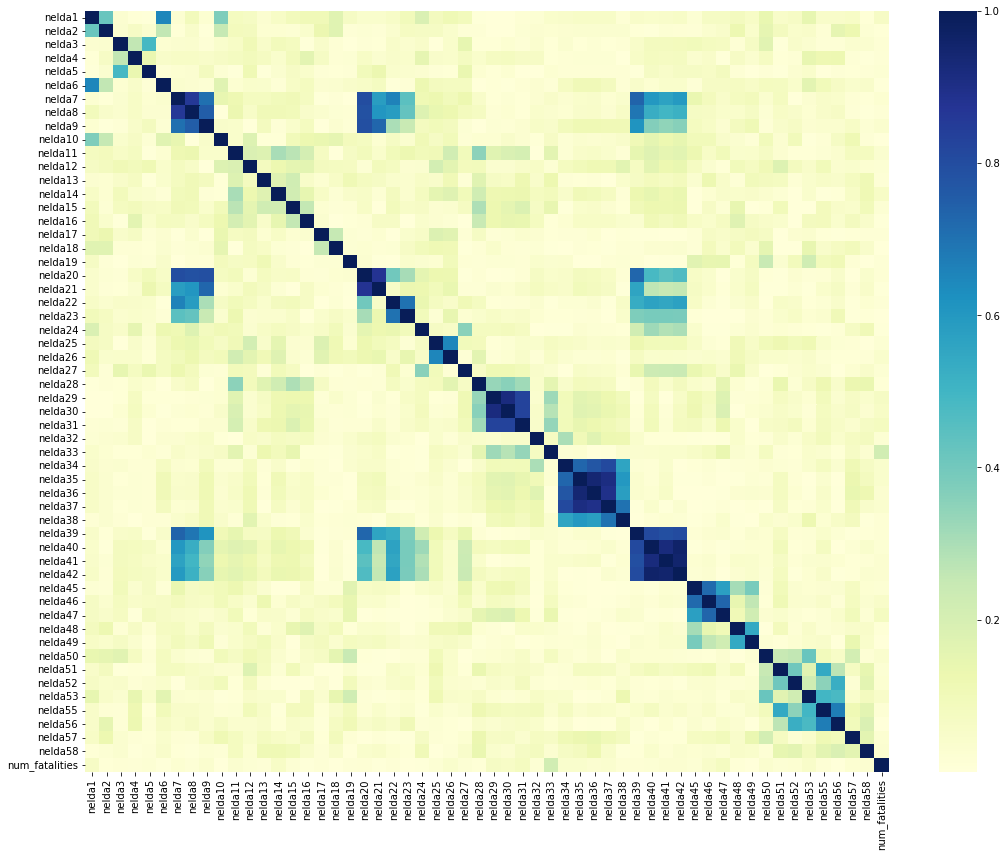

In [69]:
# visualize correlation matrix of NELDA risk factors

# calculate correlations
corr_matrix = combined_nelda_deco.corr().abs()
mask = np.triu(np.ones_like(corr_matrix))

# examine correlations 
plt.figure(figsize=(18,14))
sns.heatmap(corr_matrix[corr_matrix>=0], cmap='YlGnBu')
plt.show()

### 3.4. Remove Multicolinearity

In [70]:
# keep the features that capture most of the information of those they are highly correlated with

combined_nelda_deco = combined_nelda_deco.drop(columns=['nelda8','nelda21', 'nelda29',
                                                'nelda36', 'nelda37',
                                                'nelda40', 'nelda41'])

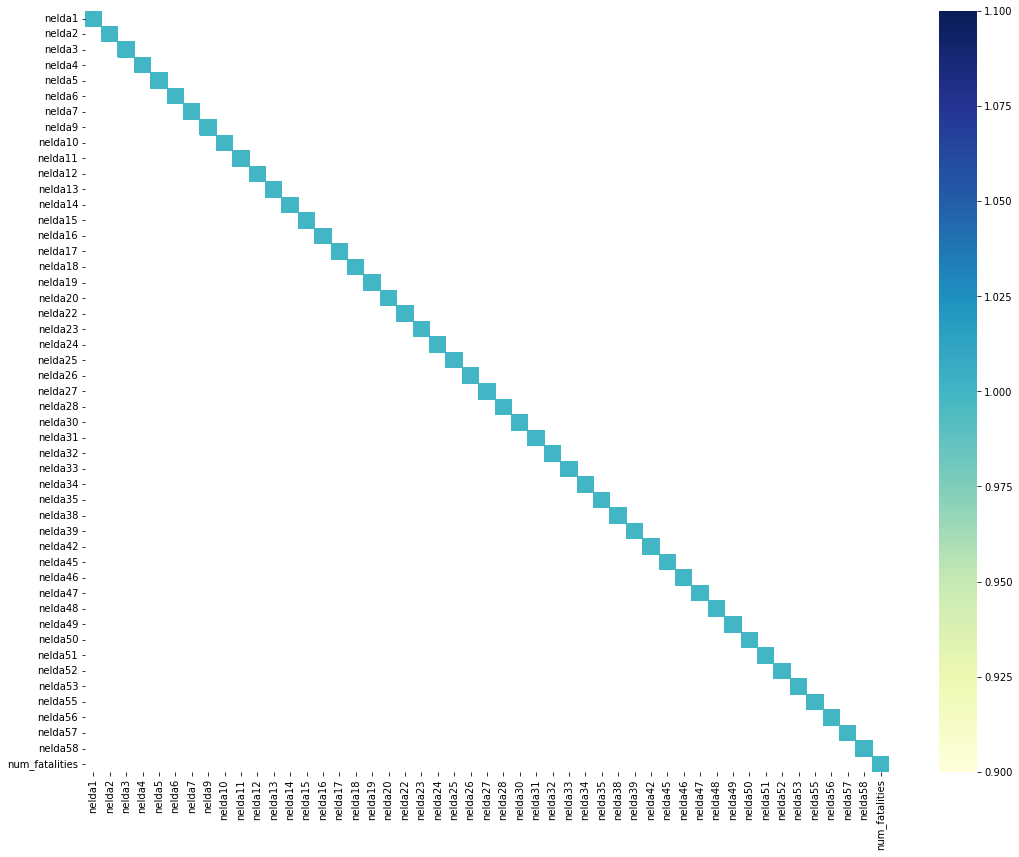

In [71]:
# confirm we have removed cases of high correlation

plt.figure(figsize=(18,14))
corr_matrix = combined_nelda_deco.corr().abs()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix[corr_matrix>=.85], cmap='YlGnBu')
plt.show()

# 4. Model Building

### 4.1 Define features and target variable 

In [72]:
# convert target variable of fatalities to a categorical variable

def to_categorial(val):
    if val == 0:
        return 'non-fatal'
    if 1 < val <= 3:
        return 'low fatality'
    else:
        return 'mass fatality'

In [73]:
# apply categorical conversion function

combined_nelda_deco['election_fatalities'] = [to_categorial(row) for row in combined_nelda_deco.num_fatalities]

In [74]:
# drop column with continuous value of fatalities

combined_nelda_deco = combined_nelda_deco.drop(['num_fatalities'], axis=1)

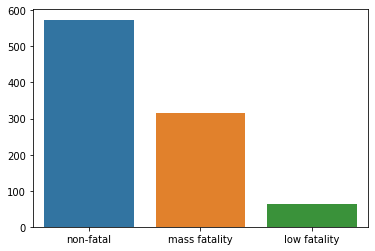

In [75]:
# view the distribution of three classes of election violence intensity

vl_ct = combined_nelda_deco.election_fatalities.value_counts()
sns.barplot(x=list(vl_ct.keys()),
           y=vl_ct.values)
plt.show()

In [76]:
# define dataframe of features (risk factors) and target variable (election fatalities)

y = combined_nelda_deco.election_fatalities
X = combined_nelda_deco.drop(['election_fatalities'], axis=1)

In [77]:
# drop columns that contain information about election fatalities the model may cheat on
# nelda 33 explicitly codes for the presence of fatalities
# nelda 31 codes for the use of violence by the government against citizens

X = X.drop(columns=['nelda33', 'nelda31'])

In [78]:
# transform all categorical NELDA features to one-hot encoding

all_columns = list(X) # Creates list of all column headers
X[all_columns] = X[all_columns].astype(str)
X_one = pd.get_dummies(X)

In [79]:
# view final transformed dataframe for prediction

X_one

,nelda1_1,nelda1_2,nelda2_-1,nelda2_1,nelda2_2,nelda3_1,nelda3_2,nelda4_-1,nelda4_1,nelda4_2,nelda5_1,nelda5_2,nelda6_-1,nelda6_0,nelda6_1,nelda6_2,nelda7_-1,nelda7_0,nelda7_1,nelda7_2,nelda9_-1,nelda9_0,nelda9_1,nelda9_2,nelda10_-1,nelda10_1,nelda10_2,nelda11_-1,nelda11_1,nelda11_2,nelda12_-1,nelda12_0,nelda12_1,nelda12_2,nelda13_-1,nelda13_0,nelda13_1,nelda13_2,nelda14_-1,nelda14_0,nelda14_1,nelda14_2,nelda15_-1,nelda15_0,nelda15_1,nelda15_2,nelda16_-1,nelda16_0,nelda16_1,nelda16_2,...,nelda45_1,nelda45_2,nelda46_-1,nelda46_0,nelda46_1,nelda46_2,nelda47_-1,nelda47_0,nelda47_1,nelda47_2,nelda48_-1,nelda48_0,nelda48_1,nelda48_2,nelda49_-1,nelda49_0,nelda49_1,nelda49_2,nelda50_-1,nelda50_0,nelda50_1,nelda50_2,nelda51_-1,nelda51_0,nelda51_1,nelda51_2,nelda52_-1,nelda52_0,nelda52_1,nelda52_2,nelda53_-1,nelda53_0,nelda53_1,nelda53_2,nelda55_-1,nelda55_0,nelda55_1,nelda55_2,nelda56_-1,nelda56_0,nelda56_1,nelda56_2,nelda57_-1,nelda57_0,nelda57_1,nelda57_2,nelda58_-1,nelda58_0,nelda58_1,nelda58_2
0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
948,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
949,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
950,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0


In [80]:
# Adjust class imblance to improve model performance via under/oversampling

# undersample the non-fatal class
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_one, y)

# oversample the other classes to eliminate class imbalance 
oversample = RandomOverSampler(sampling_strategy='all', random_state=42)
X_over, y_over = oversample.fit_resample(X_under, y_under)

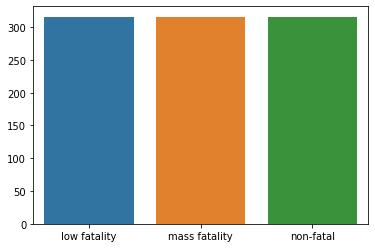

In [81]:
# view rebalanced classes

vl_ct = y_over.value_counts()
sns.barplot(x=list(vl_ct.keys()),
           y=vl_ct.values)
plt.show()

### 4.2 Train Test Split

In [82]:
# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_over, 
                                                    y_over, 
                                                    test_size=.2, 
                                                    random_state=42, 
                                                    stratify=y_over)

### 4.3 Feature selection using Boruta

In [ ]:
# define a random forest model 

rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0, 
                                criterion='gini')

In [ ]:
# use boruta to run feature selection which returns statistically significant features

boruta = BorutaPy(
   estimator = rf_clf, 
   n_estimators = 1000,
   max_iter = 100, # number of trials to perform
   random_state=42) 

In [ ]:
# fit Boruta (it accepts np.array, not pd.DataFrame)

boruta.fit(np.array(X_train), np.array(y_train))
# print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features found to be STRONGLY statistically significant:\n', green_area)
print('\n\n\nfeatures found to be WEAKLY statistically significant:\n', blue_area)

features found to be STRONGLY statistically significant:
 ['nelda1_1', 'nelda1_2', 'nelda2_1', 'nelda2_2', 'nelda4_-1', 'nelda4_2', 'nelda6_0', 'nelda6_1', 'nelda6_2', 'nelda7_0', 'nelda7_1', 'nelda7_2', 'nelda9_0', 'nelda9_1', 'nelda11_-1', 'nelda11_1', 'nelda11_2', 'nelda12_-1', 'nelda12_1', 'nelda12_2', 'nelda13_1', 'nelda13_2', 'nelda14_1', 'nelda14_2', 'nelda15_1', 'nelda15_2', 'nelda16_-1', 'nelda16_1', 'nelda16_2', 'nelda17_1', 'nelda17_2', 'nelda18_1', 'nelda18_2', 'nelda19_1', 'nelda19_2', 'nelda20_1', 'nelda20_2', 'nelda22_0', 'nelda22_1', 'nelda23_0', 'nelda23_1', 'nelda23_2', 'nelda24_0', 'nelda24_1', 'nelda24_2', 'nelda25_-1', 'nelda25_1', 'nelda25_2', 'nelda26_0', 'nelda26_1', 'nelda26_2', 'nelda27_1', 'nelda27_2', 'nelda28_-1', 'nelda28_0', 'nelda28_1', 'nelda28_2', 'nelda30_0', 'nelda30_1', 'nelda30_2', 'nelda39_1', 'nelda39_2', 'nelda42_0', 'nelda42_1', 'nelda45_1', 'nelda45_2', 'nelda46_-1', 'nelda46_0', 'nelda46_2', 'nelda47_0', 'nelda47_1', 'nelda47_2', 'nelda48_-1'

In [ ]:
# transform the dataset based on feature selection

# reduce number of features to those identified as statistically important from Boruta 
X_train_t = boruta.transform(np.array(X_train))
X_test_t = boruta.transform(np.array(X_test))

In [ ]:
# size of reduced features dataset

print('Original Dataset size:', len(X_train.columns))
print('Reduced Features Dataset:', X_train_t.shape[1])

Original Dataset size: 166
Reduced Features Dataset: 95


### 4.4 Search for Optimal Parameters

In [ ]:
parameters = {'n_estimators':[200, 600, 1000],
              'max_depth':[3, 4, 5], 
              'criterion': ['gini']}
rf_model = RandomForestClassifier()
rf_grid_cv = GridSearchCV(rf_model, parameters, verbose=1, cv=5)

In [ ]:
rf_grid_cv.fit(X_train_t, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   31.7s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [3, 4, 5],
                         'n_estimators': [200, 600, 1000]},
             verbose=1)

In [ ]:
rf_grid_cv.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000}

### 4.5 Train Model

In [ ]:
# train the model
# use initial model that proved to have best parameters

rf_clf.fit(X_train_t, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x1469EE540)

In [ ]:
# get predictions

y_pred = rf_clf.predict(X_test_t)

In [ ]:
# training accuracy

rf_clf.score(X_train_t, y_train)

0.8430079155672823

In [ ]:
# testing accuracy

rf_clf.score(X_test_t, y_test)

0.7842105263157895

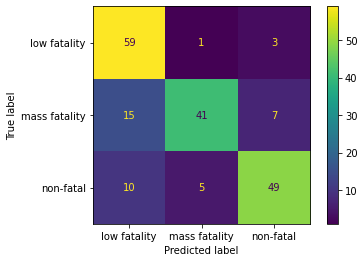

In [ ]:
# more granular view of model performance via confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_clf.classes_)
disp.plot()
plt.show()

In [ ]:
# examine precision and recall from classification report

clf_rpt = classification_report(y_test, y_pred, target_names=rf_clf.classes_)
print(clf_rpt)

               precision    recall  f1-score   support

 low fatality       0.70      0.94      0.80        63
mass fatality       0.87      0.65      0.75        63
    non-fatal       0.83      0.77      0.80        64

     accuracy                           0.78       190
    macro avg       0.80      0.78      0.78       190
 weighted avg       0.80      0.78      0.78       190



### 4.6 Feature Importance

In [ ]:
# determine feature importances 

r = permutation_importance(rf_clf, X_test_t, y_test,
                           n_repeats=10,
                           random_state=0)

perm_optimized = pd.DataFrame(columns=['AVG_Importance'], index=X_test.columns[boruta.support_])
perm_optimized['AVG_Importance'] = r.importances_mean

perm_optimized = perm_optimized.sort_values('AVG_Importance', ascending=False)
perm_optimized[:20]

,AVG_Importance
nelda14_2,0.011579
nelda14_1,0.010000
nelda12_1,0.010000
nelda30_1,0.006842
nelda20_1,0.006842
nelda53_1,0.006316
nelda51_1,0.005789
nelda57_2,0.005263
nelda53_2,0.005263
nelda28_2,0.004737


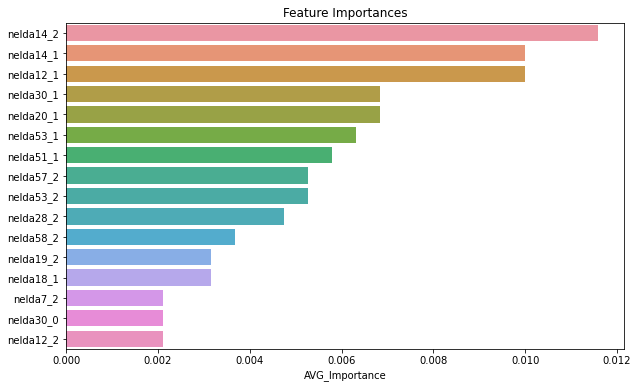

In [ ]:
# visualize feature importances

plt.figure(figsize=(10,6))
sns.barplot(x=perm_optimized.AVG_Importance[:20],
            y=perm_optimized.index[:20])

plt.title('Feature Importances')
plt.show()

In [ ]:
# select features with importance above threshold

importance_threshold = 0.002
perm_optimized = perm_optimized.loc[perm_optimized.AVG_Importance > importance_threshold]

# 5. Obtain Top Risk Factors of Historical Election Violence 

In [ ]:
# get top most important risk factors to predicting historical election violence 

top_nelda_codes = [re.findall(r'nelda\d{1,2}',row) for row in perm_optimized.index]
top_nelda_codes = pd.DataFrame(np.concatenate(top_nelda_codes), columns=['nelda_feature'])

top_unique_nelda_codes = list(top_nelda_codes.nelda_feature.unique())
top_unique_nelda_codes

['nelda14',
 'nelda12',
 'nelda30',
 'nelda20',
 'nelda53',
 'nelda51',
 'nelda57',
 'nelda28',
 'nelda58',
 'nelda19',
 'nelda18',
 'nelda7']

In [ ]:
# look up text descriptions of top NELDA risk factors

top_nelda_code_descriptions = nelda_look_up.loc[nelda_look_up.nelda_code.isin(top_unique_nelda_codes)][['nelda_code', 'description_clean']]
top_nelda_code_descriptions.reset_index(inplace=True, drop=True)
top_nelda_code_descriptions

,nelda_code,description_clean
0,nelda7,"Before elections, were there clear indications..."
1,nelda12,Was the incumbent or ruling party confident of...
2,nelda14,Did some opposition leaders boycott the election?
3,nelda18,Is country said to be in an economic crisis?
4,nelda19,Is country said to be a large recipient of out...
5,nelda20,Was the office of the incumbent leader contest...
6,nelda28,Is there evidence that reports critical of the...
7,nelda30,If there were riots and protests after the ele...
8,nelda51,Is there a negative change in relations with t...
9,nelda53,Is the country said to have a substantial econ...


In [ ]:
# save top risk factors of election violence for use in Part 2

top_nelda_code_descriptions.to_csv('../data/part_1_top_risk_factors_FINAL_BEST.csv')